Section 0 - Imports and other background information

In [2]:
import pandas as pd
import numpy as np
from os import path
import json
import matplotlib.pyplot as plt
import soundfile as sf
import wave
%matplotlib inline

In [7]:
!pip install librosa

In [8]:
import librosa, librosa.display

Before we start, note that the metadata and songs have been downloaded locally into "Data" folder using the other Python Scripts available in this github repository (see SongDownload and MetaDataDownload). The total size of this data exceeds 60 GB, so I do not recommend downloading these yourself

**Section 1** - MetaData, Basic Upvotes/Downvotes counts and removal of unneeded columns

Some basic analysis about upvote and downvotes. Also shows the determination that we will not be able to use the "rating scores" from BeastSaber as they are not consistent enough to train the algorithm.

Removes some of the data that we have columns for, but will not be using

In [4]:
meta_df = pd.read_csv("./Data/Metadata.csv", index_col=0)
meta_df.head()

,key,level_author_name,song_name,song_sub_name,bpm,upvotes,downvotes,plays,upload_date,downloads,download_url,overall_rating,fun_factor,rhythm,flow,pattern_quality,readability,level_quality
0,579f,wh4t,Without Warning,NaN,200.000000,0,0,0,2019-07-18T04:03:55.017Z,23,/api/download/key/579f,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,579e,CyanSnow,This is (not) the end,NaN,128.018005,1,0,0,2019-07-18T02:48:39.996Z,55,/api/download/key/579e,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,579d,nolan121405,Good Morning World,NaN,191.000000,0,0,0,2019-07-18T02:42:25.409Z,71,/api/download/key/579d,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,579b,Keiichi Okabe,Three's Song,NaN,230.000000,0,0,0,2019-07-18T01:37:45.214Z,39,/api/download/key/579b,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,579a,Kikis,Gee,NaN,200.000000,0,0,0,2019-07-18T01:13:44.990Z,117,/api/download/key/579a,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# All songs with no upvotes
print("Number songs with no up or downvotes: " + str(meta_df[(meta_df.upvotes == 0) & (meta_df.downvotes == 0)]["key"].count()))
print("Number songs with at least one up or downvote: " + str(meta_df[(meta_df.upvotes != 0) | (meta_df.downvotes != 0)]["key"].count()))
print("Number songs with at least one upvote and no downvotes: " + str(meta_df[(meta_df.upvotes != 0) & (meta_df.downvotes == 0)]["key"].count()))
print("Number songs with at least one downvote and no upvotes: " + str(meta_df[(meta_df.upvotes == 0) & (meta_df.downvotes != 0)]["key"].count()))
print("Number songs with a rating score: " + str(meta_df[meta_df.overall_rating != 0]["key"].count()))
print("Number songs with no rating score: " + str(meta_df[meta_df.overall_rating == 0]["key"].count()))

Number songs with no up or downvotes: 211
Number songs with at least one up or downvote: 14549
Number songs with at least one upvote and no downvotes: 1412
Number songs with at least one downvote and no upvotes: 689
Number songs with a rating score: 5390
Number songs with no rating score: 9370


Unfortunately, this seems to indicate that the "rating scores" for the songs will not be a viable method to determine the quality of the map as only about 1/3 of them have been rated. As such, upvotes and downvotes seem to be a more stable value to feed to any learning algorithms.

In [6]:
# Get rid of the ratings columns as we won't be able to reliably use that data
meta_df.drop('overall_rating', axis=1, inplace=True)
meta_df.drop('fun_factor', axis=1, inplace=True)
meta_df.drop('rhythm', axis=1, inplace=True)
meta_df.drop('flow', axis=1, inplace=True)
meta_df.drop('pattern_quality', axis=1, inplace=True)
meta_df.drop('readability', axis=1, inplace=True)
meta_df.drop('level_quality', axis=1, inplace=True)

In [7]:
# We also no longer need the download url as that is determined based on the key
meta_df.drop('download_url', axis=1, inplace=True)

Raw counts of upvotes and downvotes are not as useful as some other possible metrics (e.g. 80 downvotes isn't bad if there are 800 upvotes). So let's look at the net number of votes (upvotes - downvotes) and the percentage of upvotes out of all votes.

Note that in order to do the second we will need to drop any rows where we do not have any upvotes or downvotes. However, this is okay since we don't have any other metric to make a judgement call on whether a map is "good" or not (Also, there are only 211 of them which is not terribly significant when looking at over 14000 songs).

In [8]:
meta_df["net_votes"] = meta_df["upvotes"] - meta_df["downvotes"]
meta_df = meta_df[(meta_df.upvotes != 0) | (meta_df.downvotes != 0)]
meta_df["percent_upvotes"] = meta_df["upvotes"] / (meta_df["upvotes"] + meta_df["downvotes"])
meta_df.head()

,key,level_author_name,song_name,song_sub_name,bpm,upvotes,downvotes,plays,upload_date,downloads,net_votes,percent_upvotes
1,579e,CyanSnow,This is (not) the end,NaN,128.018005,1,0,0,2019-07-18T02:48:39.996Z,55,1,1.0
5,5799,Hoops521,Stuck In Your Head,NaN,155.000000,0,2,0,2019-07-18T00:56:50.710Z,91,-2,0.0
6,5798,Fraktar,Kakariko Crypt - Cadence of Hyrule,NaN,120.000000,2,0,0,2019-07-18T00:31:14.072Z,118,2,1.0
7,5797,Rigid,Balalaika,NaN,140.000000,3,0,0,2019-07-17T23:03:08.933Z,210,3,1.0
8,5796,Creeel,Temmie Village (Genocide Version) - Undertale,NaN,75.300003,3,0,0,2019-07-17T23:01:03.565Z,122,3,1.0


In [9]:
print("Number songs positive net votes: " + str(meta_df[meta_df.net_votes > 0]["key"].count()))
print("Number songs neutral net votes: " + str(meta_df[meta_df.net_votes == 0]["key"].count()))
print("Number songs negative net votes: " + str(meta_df[meta_df.net_votes < 0]["key"].count()))
print("Number songs with more than 80 percent positive votes: " + str(meta_df[meta_df.percent_upvotes > .8]["key"].count()))

Number songs positive net votes: 10216
Number songs neutral net votes: 629
Number songs negative net votes: 3704
Number songs with more than 80 percent positive votes: 6682


In [10]:
# Write out the information back into a CSV file
meta_df.to_csv("./Data/Metadata2.csv")

**Section 2** - Gathering Song Difficulty counts

The basic metadata is not enough to tell what is going on with each song. We also want to know which difficulties they support (note that difficulty information could have been grabbed during the initial data gathering phase, but I unfortunately missed that part and would rather not make another set of 1400+ API calls to the BeatSaver server to gather it from there as I doubt the owner of the server would be happy with me)

In [11]:
# Read back from the file in case section 1 is skipped over
diff_df = pd.read_csv("./Data/Metadata2.csv", index_col=0)

Look at the local file system to see if we have a file with the data we need for each of the different difficulties
*Note that this operation won't work without all of the songs downloaded*

Like the other portions of this analysis, the metadata itself will be written back out to CSV after complete

In [12]:
diff_df["easy"] = diff_df.apply(lambda row: path.exists("./Data/{}/Easy.dat".format(row.key)), axis=1)
diff_df["normal"] = diff_df.apply(lambda row: path.exists("./Data/{}/Normal.dat".format(row.key)), axis=1)
diff_df["hard"] = diff_df.apply(lambda row: path.exists("./Data/{}/Hard.dat".format(row.key)), axis=1)
diff_df["expert"] = diff_df.apply(lambda row: path.exists("./Data/{}/Expert.dat".format(row.key)), axis=1)
diff_df["expertplus"] = diff_df.apply(lambda row: path.exists("./Data/{}/ExpertPlus.dat".format(row.key)), axis=1)
diff_df.to_csv("./Data/Metadata3.csv")
diff_df.head()

,key,level_author_name,song_name,song_sub_name,bpm,upvotes,downvotes,plays,upload_date,downloads,net_votes,percent_upvotes,easy,normal,hard,expert,expertplus
1,579e,CyanSnow,This is (not) the end,NaN,128.018005,1,0,0,2019-07-18T02:48:39.996Z,55,1,1.0,False,False,False,True,False
5,5799,Hoops521,Stuck In Your Head,NaN,155.000000,0,2,0,2019-07-18T00:56:50.710Z,91,-2,0.0,False,False,False,True,True
6,5798,Fraktar,Kakariko Crypt - Cadence of Hyrule,NaN,120.000000,2,0,0,2019-07-18T00:31:14.072Z,118,2,1.0,False,False,False,True,False
7,5797,Rigid,Balalaika,NaN,140.000000,3,0,0,2019-07-17T23:03:08.933Z,210,3,1.0,False,False,True,True,False
8,5796,Creeel,Temmie Village (Genocide Version) - Undertale,NaN,75.300003,3,0,0,2019-07-17T23:01:03.565Z,122,3,1.0,False,False,False,True,False


**Section 3** - Removing Songs with no difficulties

After a preliminary examination of the data, it is possible to notice that some of the songs that we downloaded do not have any correct difficulty mapping (or they decided to define their *own* difficulty mapping.

Songs where that is the case have nothing to offer so they need to be removed from our data set

In [13]:
# Calculate the number of songs where we didn't get a single difficulty type
diff_df2 = pd.read_csv("./Data/Metadata3.csv", index_col=0)
diff_df2[(diff_df2.easy == False) & (diff_df2.normal == False) & (diff_df2.hard == False) & (diff_df2.expert == False) & (diff_df2.expertplus == False)]["key"].count()

46

In [14]:
print("Before drop: " + str(diff_df2["key"].count()))
diff_df2 = diff_df2[(diff_df2.easy != False) | (diff_df2.normal != False) | (diff_df2.hard != False) | (diff_df2.expert != False) | (diff_df2.expertplus != False)]
print("After drop: " + str(diff_df2["key"].count()))
diff_df2.to_csv("./Data/Metadata4.csv")

Before drop: 14549
After drop: 14503


**Section 4** - Difficulty analysis and cleanup of a few of the other pieces of metadata

Number easy: 1238
Number normal: 2124
Number hard: 4531
Number expert: 8314
Number expertplus: 5087


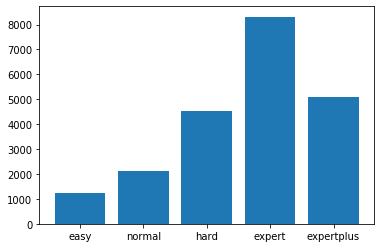

In [15]:
diff_counts = {"easy": diff_df2[diff_df2.easy == True]["key"].count(),
              "normal": diff_df2[diff_df2.normal == True]["key"].count(),
              "hard": diff_df2[diff_df2.hard == True]["key"].count(),
              "expert": diff_df2[diff_df2.expert == True]["key"].count(),
              "expertplus": diff_df2[diff_df2.expertplus == True]["key"].count()}

print("Number easy: " + str(diff_counts["easy"]))
print("Number normal: " + str(diff_counts["normal"]))
print("Number hard: " + str(diff_counts["hard"]))
print("Number expert: " + str(diff_counts["expert"]))
print("Number expertplus: " + str(diff_counts["expertplus"]))

plt.bar(range(len(diff_counts)), diff_counts.values(), align='center')
plt.xticks(range(len(diff_counts)), list(diff_counts.keys()))

plt.show()

So it looks like we will unfortunately not be able to have a very clean idea of the different difficulties since there are not as many as we would like. Easy in particular will not be able to mapped very cleanly with only 1238 different songs

Now,there are 4 final pieces of information about songs that we are missing (and could have grabbed during the intitial hit against the API) so we are going to dig into the json info files in order to get that info out and examine. Those pieces of data are listed as "Song time offset", "Shuffle", "Shuffle Period", and then (perhaps the most important) the actual filename of the song on disk (to make it easy to grab the song itself)

In [16]:
def get_missing_row_info(row):
    with open('./Data/{}/info.dat'.format(row.key), errors="ignore", encoding="utf-8") as json_file:
        data = json.load(json_file)
        return data["_songTimeOffset"], data["_shuffle"], data["_shufflePeriod"], data["_songFilename"]

In [17]:
# Note that this operation can take a minute or two to complete and will only work with the songs downloaded locally
diff_df2["song_offset"], diff_df2["shuffle"], diff_df2["shuffle_period"], diff_df2["filename"] = zip(*diff_df2.apply(get_missing_row_info, axis=1))
diff_df2[diff_df2.shuffle != 0.0].head()

,key,level_author_name,song_name,song_sub_name,bpm,upvotes,downvotes,plays,upload_date,downloads,...,percent_upvotes,easy,normal,hard,expert,expertplus,song_offset,shuffle,shuffle_period,filename
2799,485a,Funrankable,Lost in the Rhythm,Jamie Berry ft. Octavia Rose,121.0,207,4,0,2019-04-25T19:03:46.000Z,6293,...,0.981043,True,True,True,True,True,0.0,0.25,0.25,song.egg
4297,3e9f,Sykes19,Flower Mountain Canyon (Stage 2) - Spark the E...,James Landino,105.0,81,4,0,2019-03-18T02:45:18.000Z,3682,...,0.952941,True,True,True,True,True,0.0,0.20,0.25,flower_cut_short.egg
10712,1575,Zorowo,Lissen Buddy,Deno,100.0,3,4,16,2018-09-17T04:38:51.000Z,1021,...,0.428571,False,False,False,False,True,0.0,1.00,0.50,listenbuddy.egg


In [18]:
print("nonzero song offsets: " + str(diff_df2[diff_df2.song_offset != 0]["key"].count()))
print("nonzero song shuffle: " + str(diff_df2[diff_df2.shuffle != 0]["key"].count()))
print("nonzero song shuffle periods: " + str(diff_df2[diff_df2.shuffle_period != 0]["key"].count()))

nonzero song offsets: 3
nonzero song shuffle: 3
nonzero song shuffle periods: 14486


So it turns out that while different song offsets and shuffles are allowed, they are not really in use in the beatsaber community. As such those columns can be dropped

As an anecdote, it is important to watch out for encoding. If you don't specify utf-8 encoding the below file will break and be unable to read the accented E

In [19]:
diff_df2[diff_df2.key == "5768"]["filename"]

44    THE POKÉMON THEME - (METAL COVER) Jonathan You...
Name: filename, dtype: object

Back to dropping the unused columns and writing the output back out

In [20]:
diff_df2.drop('song_offset', axis=1, inplace=True)
diff_df2.drop('shuffle', axis=1, inplace=True)
diff_df2.to_csv("./Data/Metadata5.csv")

**Section 5** - Song Length

Song length information was included in the initial API, but it didn't seem to be exactly accurate. As such, we are going to get the actual song lengths from each of the files themselves. Note that again this operation will run against local files (and also note that it runs slowly, 10+ minutes at the time of my running)

In [21]:
def get_song_len(row):
    """Function for computing song length by using a dataframe row"""
    
    try:
        f = sf.SoundFile("./Data/{}/{}".format(row.key, row.filename))
        return len(f) / f.samplerate
    except:
        print("Error with key {} and filename {}".format(row.key, row.filename))
        return -1

In [22]:
song_len_df = pd.read_csv("./Data/Metadata5.csv", index_col=0)
song_len_df["song_length"] = song_len_df.apply(get_song_len, axis=1)
song_len_df.head()

Error with key 52cc and filename song.egg
Error with key 4fc2 and filename song.egg
Error with key 4f8b and filename song.egg
Error with key 4ec6 and filename song.egg
Error with key 4ec5 and filename song.egg
Error with key 49a9 and filename she.egg
Error with key 48b7 and filename song.egg
Error with key 4807 and filename 49 Escape From Midwitch Valley.egg
Error with key 439b and filename 44 Future Club.egg
Error with key 42b6 and filename song.egg
Error with key 3dc6 and filename song.egg
Error with key 3c4f and filename song.egg
Error with key 3aca and filename song.egg
Error with key 392f and filename the Moon is made of Cheese.egg
Error with key 36a9 and filename All I Need Are Things I Like - nameless.egg
Error with key 34ec and filename Smells Like Content.egg
Error with key 334b and filename song.egg
Error with key 319d and filename song.egg
Error with key 2f50 and filename Two Steps From Hell - Archangel.egg
Error with key 2e98 and filename song.egg
Error with key 2e29 and fi

,key,level_author_name,song_name,song_sub_name,bpm,upvotes,downvotes,plays,upload_date,downloads,net_votes,percent_upvotes,easy,normal,hard,expert,expertplus,shuffle_period,filename,song_length
1,579e,CyanSnow,This is (not) the end,NaN,128.018005,1,0,0,2019-07-18T02:48:39.996Z,55,1,1.0,False,False,False,True,False,0.5,easter.egg,160.292494
5,5799,Hoops521,Stuck In Your Head,NaN,155.000000,0,2,0,2019-07-18T00:56:50.710Z,91,-2,0.0,False,False,False,True,True,0.5,song.egg,218.098322
6,5798,Fraktar,Kakariko Crypt - Cadence of Hyrule,NaN,120.000000,2,0,0,2019-07-18T00:31:14.072Z,118,2,1.0,False,False,False,True,False,0.5,song.egg,106.019250
7,5797,Rigid,Balalaika,NaN,140.000000,3,0,0,2019-07-17T23:03:08.933Z,210,3,1.0,False,False,True,True,False,0.5,song.egg,215.902041
8,5796,Creeel,Temmie Village (Genocide Version) - Undertale,NaN,75.300003,3,0,0,2019-07-17T23:01:03.565Z,122,3,1.0,False,False,False,True,False,0.5,Temmie.egg,75.478776


In [23]:
print("Number of songs failed to open: {}".format(song_len_df[song_len_df.song_length == -1]["key"].count()))
print("Number of songs that opened successfully: {}".format(song_len_df[song_len_df.song_length != -1]["key"].count()))

Number of songs failed to open: 139
Number of songs that opened successfully: 14364


In [24]:
# We can't analyze songs that we will not be able to open, so go ahead and remove them
song_len_df = song_len_df[song_len_df.song_length != -1]
song_len_df.to_csv("./Data/Metadata6.csv")

**Section 6** - Notes, bombs, obstacles, and lighting events

So that is all for the simple metadata about a song, but now we need the information for the actual notes, bombs, obstacles, and lighting events that will be shown in each of the songs.

This will require exploding out the values so that we can have a row for each different difficulty since each difficulty of the song will have a different set of note values

Some functions to create a dictionary with lists for each of the "objects" in a song (notes, bombs, obstacles, and lighting events)

In [25]:
def create_song_dict():
    song_dict = {}
    song_dict["time"] = []
    song_dict["type"] = []
    song_dict["value"] = []
    song_dict["line_index"] = []
    song_dict["line_layer"] = []
    song_dict["cut_direction"] = []
    song_dict["duration"] = []
    song_dict["width"] = []
    song_dict["object_type"] = []
    
    return song_dict

def add_event_to_dict(song_dict, time, event_type, value):
    """Appends the values for an event to the song's dictionary"""
    song_dict["time"].append(time)
    song_dict["type"].append(event_type)
    song_dict["value"].append(value)
    song_dict["line_index"].append(np.nan) # NA on events
    song_dict["line_layer"].append(np.nan) # NA on events
    song_dict["cut_direction"].append(np.nan) # NA on events
    song_dict["duration"].append(np.nan) # NA on events
    song_dict["width"].append(np.nan) # NA on events
    song_dict["object_type"].append("Event")

    
def add_note_to_dict(song_dict, time, line_index, line_layer, note_type, cut_direction):
    """Appends the values for a note (which includes bombs) to the song's dictionary"""
    song_dict["time"].append(time)
    song_dict["type"].append(note_type)
    song_dict["value"].append(np.nan) # NA on notes/bombs
    song_dict["line_index"].append(line_index)
    song_dict["line_layer"].append(line_layer)
    song_dict["cut_direction"].append(cut_direction)
    song_dict["duration"].append(np.nan) # NA on notes/bombs
    song_dict["width"].append(np.nan) # NA on notes/bombs
    
    if (note_type == 1) or (note_type == 0):
        song_dict["object_type"].append("Note")
    else:
        song_dict["object_type"].append("Bomb")

        
def add_obstacle_to_dict(song_dict, time, line_index, obstacle_type, duration, width):
    """Appends the values for an obstacle to the song's dictionary"""
    song_dict["time"].append(time)
    song_dict["type"].append(obstacle_type)
    song_dict["value"].append(np.nan)
    song_dict["line_index"].append(line_index) # NA on obstacles
    song_dict["line_layer"].append(np.nan) # NA on obstacles
    song_dict["cut_direction"].append(np.nan) # NA on obstacles
    song_dict["duration"].append(duration) # NA on obstacles
    song_dict["width"].append(width) # NA on obstacles
    song_dict["object_type"].append("Obstacle")
    

Function to convert a song file with objects into a dataframe

In [26]:
def convert_song_to_pandas(json_file_name):
    """Grab the information from the passed in file and create it as a dataframe"""
    with open(json_file_name) as temp_json:
        temp_data = json.load(temp_json)
        temp_dict = create_song_dict()

        # Get all notes
        for note in temp_data["_notes"]:
            add_note_to_dict(temp_dict, note["_time"], note["_lineIndex"], note["_lineLayer"], 
                             note["_type"], note["_cutDirection"])

        for event in temp_data["_events"]:
            add_event_to_dict(temp_dict, event["_time"], event["_type"], event["_value"])

        for obstacle in temp_data["_obstacles"]:
            add_obstacle_to_dict(temp_dict, obstacle["_time"], obstacle["_lineIndex"], obstacle["_type"],
                                obstacle["_duration"], obstacle["_width"])
        
        # OUT OF SCOPE FOR THIS PROJECT FOR NOW
        #for bpm_change in temp_data["_BPMChanges"]
        df = pd.DataFrame(temp_dict)
        df["object_type"] = df["object_type"].astype('category')
        return df

Function to get the data for a song and write it back out as a json in pandas format (for easy re-reading) as well as returning the various pieces of metadata we were interested in

In [27]:
def get_data_for_song_file(filename):
    """Retrieve the note information from the data file and writes it back out to an easier to access json file"""
    new_filename = filename.replace(".dat", "Pandas.json")
    
    try:
        if path.exists(new_filename):
            df = pd.read_json(new_filename)
        else:
            df = convert_song_to_pandas(filename)
            df.to_json(new_filename)

        obj_group = df.groupby("object_type").size()

        num_notes = 0
        if "Note" in obj_group: 
            num_notes = obj_group["Note"]

        num_bombs = 0
        if "Bomb" in obj_group:
            num_bombs = obj_group["Bomb"]

        num_events = 0
        if "Event" in obj_group:
            num_events = obj_group["Event"]

        num_obstacles = 0
        if "Obstacle" in obj_group:
            num_obstacles = obj_group["Obstacle"]

        note_group = df[(df.object_type == "Note") & (df.type != 3)].groupby("type").size()
        num_left = 0
        if 0 in note_group:
            num_left = note_group[0]

        num_right = 0
        if 1 in note_group:
            num_right = note_group[1]

        return num_notes, num_bombs, num_events, num_obstacles, num_left, num_right
    except:
        return -1, -1, -1, -1, -1, -1
    

Function to apply to each pandas row in order to run the above function and get the metadata for the row

In [28]:
def get_note_info_for_row(row):
    """Retrieves the note/bomb/event/obstacle information for a pandas row that is passed to it"""
    if row.difficulty == "easy":
        file_name = "Easy.dat"
    elif row.difficulty == "normal":
        file_name = "Normal.dat"
    elif row.difficulty == "hard":
        file_name = "Hard.dat"
    elif row.difficulty == "expertplus":
        file_name = "ExpertPlus.dat"
    else:
        file_name = "Expert.dat"
        
    
    file_name = "./Data/{}/{}".format(row.key, file_name)
    #print("Trying {}".format(file_name))
    return get_data_for_song_file(file_name)

Creates a copy of the dataframe with each of the difficulties, stitches them back together so that there is one row per song per difficulty, creates a new column to hold the difficulty, and then deletes the old "easy", "normal" columns

In [29]:
old_df = pd.read_csv("./Data/Metadata6.csv", index_col=0)
new_df = old_df.head(0).copy()

for difficulty in ["easy", "normal", "hard", "expert", "expertplus"]:
    temp_df = old_df[old_df[difficulty] == True].copy()
    temp_df["difficulty"] = difficulty
    
    new_df = new_df.append(temp_df, ignore_index=True)

for difficulty in ["easy", "normal", "hard", "expert", "expertplus"]:
    new_df.drop(difficulty, axis=1, inplace=True)

new_df.head()

C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,bpm,difficulty,downloads,downvotes,filename,key,level_author_name,net_votes,percent_upvotes,plays,shuffle_period,song_length,song_name,song_sub_name,upload_date,upvotes
0,100.0,easy,74,1,song.egg,578f,Keule,-1,0.000000,0,0.5,136.933878,Home-Neffex,NaN,2019-07-17T16:17:27.247Z,0
1,133.0,easy,631,0,song.egg,5788,Joetastic,12,1.000000,0,0.5,110.995510,Tsukiakari no Michishirube,NaN,2019-07-17T10:53:02.203Z,12
2,164.0,easy,513,1,song.egg,575d,Rigid,12,0.928571,0,0.5,129.137959,Take a Hint feat. Victoria Justice & Elizabeth...,NaN,2019-07-16T17:38:03.118Z,13
3,188.0,easy,194,1,Igorrr & Ruby My Dear - Biquette short.egg,574e,219278,0,0.500000,0,0.5,165.466599,Biquette,Short Ver.,2019-07-16T05:27:17.350Z,1
4,132.0,easy,445,0,song.egg,5714,ETAN,5,1.000000,0,0.5,92.481156,Saikousoku Fall in Love,NaN,2019-07-14T22:09:46.361Z,5


Performs the operations on all of the pandas rows so that we have basic note metadata

In [30]:
new_df["num_notes"], new_df["num_bombs"], new_df["num_events"], new_df["num_obstacles"], new_df["num_left_notes"], new_df["num_right_notes"] = zip(*new_df.apply(get_note_info_for_row, axis=1))
new_df.head()

C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,bpm,difficulty,downloads,downvotes,filename,key,level_author_name,net_votes,percent_upvotes,plays,...,song_name,song_sub_name,upload_date,upvotes,num_notes,num_bombs,num_events,num_obstacles,num_left_notes,num_right_notes
0,100.0,easy,74,1,song.egg,578f,Keule,-1,0.000000,0,...,Home-Neffex,NaN,2019-07-17T16:17:27.247Z,0,220,0,107,31,110,110
1,133.0,easy,631,0,song.egg,5788,Joetastic,12,1.000000,0,...,Tsukiakari no Michishirube,NaN,2019-07-17T10:53:02.203Z,12,148,0,1147,4,72,76
2,164.0,easy,513,1,song.egg,575d,Rigid,12,0.928571,0,...,Take a Hint feat. Victoria Justice & Elizabeth...,NaN,2019-07-16T17:38:03.118Z,13,237,0,1264,4,116,121
3,188.0,easy,194,1,Igorrr & Ruby My Dear - Biquette short.egg,574e,219278,0,0.500000,0,...,Biquette,Short Ver.,2019-07-16T05:27:17.350Z,1,1042,0,6819,148,524,518
4,132.0,easy,445,0,song.egg,5714,ETAN,5,1.000000,0,...,Saikousoku Fall in Love,NaN,2019-07-14T22:09:46.361Z,5,125,4,5794,2,62,63


In [31]:
print("Number of songs with no notes: {}".format(new_df[new_df.num_notes == 0]["key"].count()))
new_df[new_df.num_notes == 0].head()

Number of songs with no notes: 145


,bpm,difficulty,downloads,downvotes,filename,key,level_author_name,net_votes,percent_upvotes,plays,...,song_name,song_sub_name,upload_date,upvotes,num_notes,num_bombs,num_events,num_obstacles,num_left_notes,num_right_notes
11,208.0,easy,161,2,song.egg,56e4,Souk & Oddloop,0,0.500000,0,...,tinnitus,NaN,2019-07-14T00:06:00.096Z,2,0,0,12649,0,0,0
12,140.0,easy,382,0,song.egg,56d7,agoza,1,1.000000,0,...,Bad Day,NaN,2019-07-13T20:01:36.960Z,1,0,0,196,120,0,0
37,170.0,easy,2417,2,song.egg,55ae,Samuel & TheRealZeroz,58,0.967742,0,...,Bye or not,NaN,2019-07-05T15:36:58.012Z,60,0,0,11274,0,0,0
44,103.0,easy,1260,2,song.egg,5580,TheRealZeroz,19,0.913043,0,...,Sad Machine,KLOUD Remix (v2),2019-07-04T13:24:02.852Z,21,0,0,19317,0,0,0
46,140.0,easy,834,1,song.egg,5577,TranquillizeMe,13,0.933333,0,...,ShutEmDown,NaN,2019-07-04T04:13:32.489Z,14,0,0,9877,0,0,0


It seems that there are over 100 songs where the mapper didn't upload any note blocks at all. Though this may make for a nice "cinematic" feel or a good lightshow, it is not what we are looking for. Since there is nothing to salvage from those songs they will need to be removed

In [32]:
new_df = new_df[new_df.num_notes != 0]
print("Number of songs with no notes: {}".format(new_df[new_df.num_notes == 0]["key"].count()))

Number of songs with no notes: 0


In [33]:
print("Number of songs that couldn't be parsed: {}".format(new_df[new_df.num_notes == -1]["key"].count()))
new_df[new_df.num_notes == -1].head()

Number of songs that couldn't be parsed: 3


,bpm,difficulty,downloads,downvotes,filename,key,level_author_name,net_votes,percent_upvotes,plays,...,song_name,song_sub_name,upload_date,upvotes,num_notes,num_bombs,num_events,num_obstacles,num_left_notes,num_right_notes
9805,135.0,expert,388,0,videoplayback.egg,41c2,kokokouta,3,1.00,0,...,Music hour,NaN,2019-03-29T16:46:20.000Z,3,-1,-1,-1,-1,-1,-1
11435,162.0,expert,2115,4,Last Ride Of The Day.egg,2e22,wei,8,0.75,0,...,Nightwish Last Ride Of The Day,Nightwish,2019-01-16T08:36:43.000Z,12,-1,-1,-1,-1,-1,-1
17926,149.0,expertplus,860,4,song.egg,4375,wei,2,0.60,0,...,Nine nine eighty one,Yuezheng Ling,2019-04-04T20:19:13.000Z,6,-1,-1,-1,-1,-1,-1


For these three songs, it would seem that there was an error parsing them. It turns out that this was due to not having the initial JSON parsing running in utf-8. Below is the fixed version of the function call

In [34]:
def convert_song_to_pandas(json_file_name):
    """Grab the information from the passed in file and create it as a dataframe"""
    # Encoding is important in the case of people who have international characters listed in the "bookmarks" section
    with open(json_file_name, encoding="utf-8") as temp_json:  
        temp_data = json.load(temp_json)
        temp_dict = create_song_dict()

        # Get all notes
        for note in temp_data["_notes"]:
            add_note_to_dict(temp_dict, note["_time"], note["_lineIndex"], note["_lineLayer"], 
                             note["_type"], note["_cutDirection"])

        for event in temp_data["_events"]:
            add_event_to_dict(temp_dict, event["_time"], event["_type"], event["_value"])

        for obstacle in temp_data["_obstacles"]:
            add_obstacle_to_dict(temp_dict, obstacle["_time"], obstacle["_lineIndex"], obstacle["_type"],
                                obstacle["_duration"], obstacle["_width"])
        
        # OUT OF SCOPE FOR THIS PROJECT FOR NOW
        #for bpm_change in temp_data["_BPMChanges"]
        df = pd.DataFrame(temp_dict)
        df["object_type"] = df["object_type"].astype('category')
        return df

In [35]:
new_df.at[9805, "num_notes"], new_df.at[9805, "num_bombs"], new_df.at[9805, "num_events"], new_df.at[9805, "num_obstacles"], new_df.at[9805, "num_left_notes"], new_df.at[9805, "num_right_notes"] = get_data_for_song_file("./Data/41c2/Expert.dat")
new_df.at[11435, "num_notes"], new_df.at[11435, "num_bombs"], new_df.at[11435, "num_events"], new_df.at[11435, "num_obstacles"], new_df.at[11435, "num_left_notes"], new_df.at[11435, "num_right_notes"] = get_data_for_song_file("./Data/2e22/Expert.dat")
new_df.at[17926, "num_notes"], new_df.at[17926, "num_bombs"], new_df.at[17926, "num_events"], new_df.at[17926, "num_obstacles"], new_df.at[17926, "num_left_notes"], new_df.at[17926, "num_right_notes"] = get_data_for_song_file("./Data/4375/ExpertPlus.dat")
print("Number of songs that couldn't be parsed: {}".format(new_df[new_df.num_notes == -1]["key"].count()))

Number of songs that couldn't be parsed: 0


In [36]:
new_df.to_csv("./Data/Metadata7.csv")

**Section 7** - Metadata statistics and analysis

Now that we have finally grabbed all of the song metadata, we can look at the statistics to try to find outliers

In [37]:
meta_df = pd.read_csv("./Data/Metadata7.csv", index_col=0)

Statistics for number of notes at each difficulty level

In [38]:
meta_df.groupby("difficulty")["num_notes"].describe()

,count,mean,std,min,25%,50%,75%,max
difficulty,,,,,,,,
easy,1105.0,1015.686878,15868.913049,1.0,155.00,254.0,387.00,503740.0
expert,8231.0,731.550601,507.123606,1.0,495.00,683.0,887.00,20339.0
expertplus,5038.0,1136.148273,1018.575513,1.0,674.00,965.5,1316.00,22050.0
hard,4492.0,546.126892,310.717936,2.0,361.75,513.0,675.00,6753.0
normal,2108.0,403.625712,262.728077,1.0,255.00,363.0,494.25,4678.0


Seems like easy, expert, and expertplus have some pretty massive outliers, lets take a look at those

In [39]:
meta_df[meta_df.difficulty == "easy"].sort_values("num_notes", ascending=False)[["difficulty", "song_name", "num_notes", "song_length", "key"]].head(10)

,difficulty,song_name,num_notes,song_length,key
605,easy,Chaos Dunk,503740,70.460272,3134
887,easy,Self Destruct Sequence,154164,70.000000,1e15
916,easy,Dial up (Zoom Edition),22620,205.612698,1a59
7,easy,Stress Test 2,15360,64.943424,5708
9,easy,Stress Test 2,15360,64.943424,56f8
561,easy,KokorokokoroKOKOROkokoROKOkoroKOKOrokoKOROkoko...,13968,870.562540,33c7
900,easy,It's Over 9000,9001,63.581587,1c34
93,easy,Boundless (VISUAL),6207,88.790204,5314
1004,easy,Reaxt: @everyone,6119,81.055374,110d
69,easy,Uranoid,4288,204.122086,5411


Looking at the top two songs listings on BSaber, it is pretty obvious that these were joke songs that people put in to try to Crash Beat Saber. https://bsaber.com/songs/3134/ and https://bsaber.com/songs/1e15/
The bottom of the list is almost a valid song, but was obviously still mapped way outside of the "easy" category. So we need another metric to look at this (notes per second)

In [40]:
meta_df["notes_per_second"] = meta_df["num_notes"] / meta_df["song_length"]
meta_df.groupby("difficulty")["notes_per_second"].describe()

,count,mean,std,min,25%,50%,75%,max
difficulty,,,,,,,,
easy,1105.0,12.212596,225.241065,0.001087,1.135469,1.500146,2.308750,7149.276960
expert,8231.0,4.012802,3.226207,0.007053,3.153980,3.750893,4.444505,174.448381
expertplus,5038.0,6.190547,6.745594,0.020143,4.375150,5.338640,6.839331,300.773728
hard,4492.0,3.082223,1.801602,0.025031,2.418533,2.878921,3.454341,57.920739
normal,2108.0,2.311215,1.457992,0.012515,1.649991,2.055461,2.594038,29.744080


This tells the story pretty cleanly, it seems that we actually have outliers in both directions with easy having so many notes that the game will crash AND so few notes that the player is basically not playing the game. 

There is unfortunately no easy way to tell which of these songs are still mapped well (excluding the max and the min values which are obviously not), so we will have to set cutoff points. Based on this a decent cutoff point for these would seem to be about 1/4 of the 25th percentile and 4 times the 75th percentile.

In [41]:
meta_df.query("(difficulty == 'easy' and (notes_per_second < .25 or notes_per_second > 10)) or (difficulty == 'normal' and (notes_per_second < .4 or notes_per_second > 10)) or (difficulty == 'hard' and (notes_per_second < .6 or notes_per_second > 14)) or (difficulty == 'expert' and (notes_per_second < .8 or notes_per_second > 18)) or (difficulty == 'expertplus' and (notes_per_second < 1.1 or notes_per_second > 28))")["key"].count()

225

So there are 225 songs that are beyond the listed cutoff points. Removing those and then gettings statistics again gives the below

In [42]:
meta_df = meta_df.query("(difficulty != 'easy' or (notes_per_second >= .25 and notes_per_second <= 10)) and (difficulty != 'normal' or (notes_per_second >= .4 and notes_per_second <= 10)) and (difficulty != 'hard' or (notes_per_second >= .6 and notes_per_second <= 14)) and (difficulty != 'expert' or (notes_per_second >= .8 and notes_per_second <= 18)) and (difficulty != 'expertplus' or (notes_per_second >= 1.1 and notes_per_second <= 28))")
meta_df.groupby("difficulty")["notes_per_second"].describe()

,count,mean,std,min,25%,50%,75%,max
difficulty,,,,,,,,
easy,1029.0,1.991708,1.627181,0.287911,1.128521,1.459223,2.066613,9.925607
expert,8188.0,3.944029,1.304734,0.813903,3.157773,3.752757,4.444049,17.023974
expertplus,4988.0,5.888601,2.477180,1.203330,4.380548,5.336360,6.821949,26.391012
hard,4466.0,3.040551,1.042502,0.655996,2.427196,2.880997,3.454044,13.471509
normal,2078.0,2.233324,0.924324,0.484439,1.652652,2.053782,2.577432,9.967969


This looks a bit better. There will still be some songs that could use more notes and some that could use fewer, but at least the worst ones have been taken care of. So, one final output for the metadata itself and we can move onto analysis of song waveforms

In [43]:
new_df.to_csv("./Data/MetadataFinal.csv")

**Section 8** - Song waveform analysis

Analysis of songs and waveforms against their listed notes, bombs, obstacles, and lighting events.

For analysis, I am going to look at the song with highest net number of votes, "Mr. Blue Sky"

In [3]:
song_df = pd.read_csv("./Data/MetadataFinal.csv")
song_df = song_df.sort_values("net_votes", ascending=False)

In [4]:
def convert_song_egg_to_wav(filename):
    """Converts .egg files to .wav files"""
    new_file_name = filename.replace(".egg", ".wav")
    
    if not path.exists(new_file_name):
        data, sample_rate = sf.read(filename)
        
        sf.write(new_file_name, data, sample_rate)
    
    return new_file_name

In [5]:
def get_wave_and_note_df(song_row):
    # Get the wave form of the song
    wav_file = convert_song_egg_to_wav("./Data/{}/{}".format(song_row["key"], song_row["filename"]))
    waves, sample_rate = librosa.load(wav_file)
    
    # Gets the dataframe for the list of notes of the song
    notes_df = pd.read_json("./Data/{}/{}Pandas.json".format(song_row["key"], song_row["difficulty"].capitalize()))
    notes_df = notes_df.sort_values("time", ascending=True)
    notes_df["time_seconds"] = notes_df["time"] / song_row["bpm"] * 60
    
    return waves, sample_rate, notes_df

In [9]:
waves, sample_rate, notes_df = get_wave_and_note_df(song_df.iloc[0])
notes_df.head()

,time,type,value,line_index,line_layer,cut_direction,duration,width,object_type,time_seconds
470,0.0,13,1.0,NaN,NaN,NaN,NaN,NaN,Event,0.0
462,0.0,9,0.0,NaN,NaN,NaN,NaN,NaN,Event,0.0
463,0.0,8,0.0,NaN,NaN,NaN,NaN,NaN,Event,0.0
464,0.0,4,0.0,NaN,NaN,NaN,NaN,NaN,Event,0.0
465,0.0,3,0.0,NaN,NaN,NaN,NaN,NaN,Event,0.0


In [10]:
waves

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [13]:
def get_df_between_second_indices(start, end, df, obj_type):
    return df[(df.time_seconds >= start) & (df.time_seconds < end) & (df.object_type == obj_type)]

def get_waves_between_second_indices(start, end, waves, sample_rate):
    wav_start = start * sample_rate
    wav_end = min(end * sample_rate, len(waves))
    
    return waves[wav_start:wav_end]

In [14]:
def disp_plots_for_time_indices(start, end, note_df, waves, sample_rate):
    sample_df_note = get_df_between_second_indices(start, end, note_df, "Note")
    sample_df_note_blue = sample_df_note[sample_df_note.type == 0]
    sample_df_note_red = sample_df_note[sample_df_note.type == 1]
    sample_df_bomb = get_df_between_second_indices(start, end, note_df, "Bomb")
    sample_df_obstacle = get_df_between_second_indices(start, end, note_df, "Obstacle")
    sample_df_event = get_df_between_second_indices(start, end, note_df, "Event")
    plt.plot(sample_df_note_blue["time_seconds"], sample_df_note_blue["cut_direction"], "b.", 
             sample_df_note_red["time_seconds"], sample_df_note_red["cut_direction"], "r.", 
             sample_df_bomb["time_seconds"], sample_df_bomb["cut_direction"], "ko",
             sample_df_obstacle["time_seconds"], sample_df_obstacle["duration"], "cx",
             sample_df_event["time_seconds"], sample_df_event["type"], "g.")
    
    axes = plt.gca()
    axes.set_xlim([start, end])
    
    plt.show()
    
    wave_sample = get_waves_between_second_indices(start, end, waves, sample_rate)
    librosa.display.waveplot(wave_sample, sample_rate, alpha=0.8)

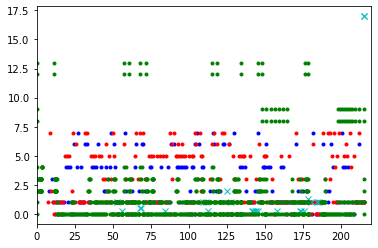

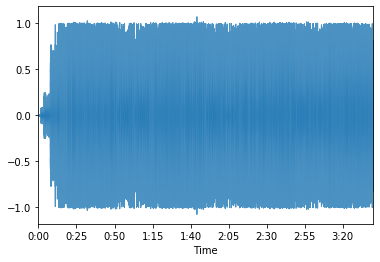

In [15]:
disp_plots_for_time_indices(0, int(notes_df["time_seconds"].max()), notes_df, waves, sample_rate)

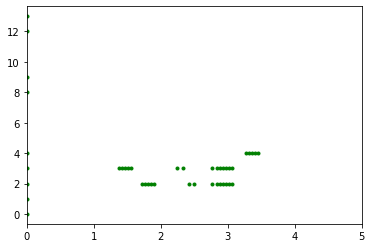

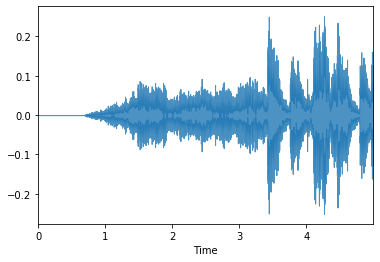

In [16]:
disp_plots_for_time_indices(0, 5, notes_df, waves, sample_rate)

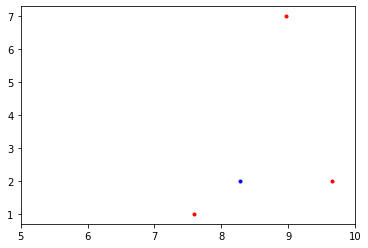

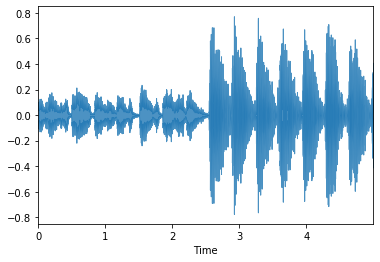

In [17]:
disp_plots_for_time_indices(5, 10, notes_df, waves, sample_rate)

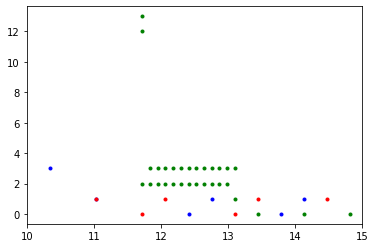

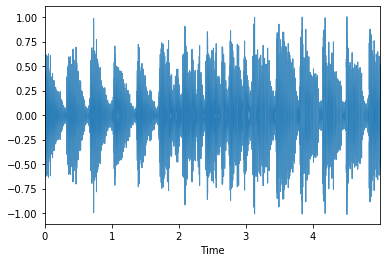

In [18]:
disp_plots_for_time_indices(10, 15, notes_df, waves, sample_rate)

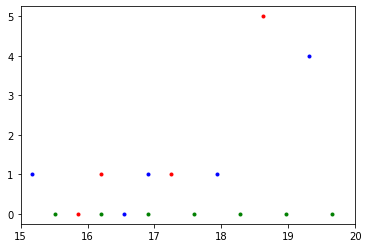

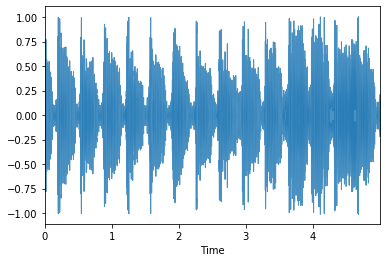

In [19]:
disp_plots_for_time_indices(15, 20, notes_df, waves, sample_rate)

Just looking at those plots it seems like there are a few seconds of lead-in time with no notes (just lighting events) and then in general the notes fall on or near the "onsets" of the waveform. It doesn't seem like all of the onsets are used, but that may be because we are currently looking at a "normal" difficulty song. Let's compare that to the same song on Expert mode (index 2)

In [55]:
song_df.head()

,Unnamed: 0,bpm,difficulty,downloads,downvotes,filename,key,level_author_name,net_votes,percent_upvotes,...,song_name,song_sub_name,upload_date,upvotes,num_notes,num_bombs,num_events,num_obstacles,num_left_notes,num_right_notes
2969,3099,174.0,normal,285623,88,song.egg,570,greatyazer,4501,0.981185,...,Mr. Blue Sky,Electric Light Orchestra,2018-06-16T16:53:34.000Z,4589,462,0,816,25,222,240
7179,7312,174.0,hard,285623,88,song.egg,570,greatyazer,4501,0.981185,...,Mr. Blue Sky,Electric Light Orchestra,2018-06-16T16:53:34.000Z,4589,639,0,816,40,310,329
15074,15213,174.0,expert,285623,88,song.egg,570,greatyazer,4501,0.981185,...,Mr. Blue Sky,Electric Light Orchestra,2018-06-16T16:53:34.000Z,4589,825,0,816,40,407,418
7588,7721,149.0,hard,347330,254,song.egg,124,jobas,4348,0.947694,...,Rasputin (Funk Overload),NaN,2018-05-19T16:36:34.000Z,4602,768,0,1109,154,390,378
15753,15892,132.0,expert,445063,187,song.egg,141,greatyazer,4322,0.960179,...,Gangnam Style,PSY,2018-05-20T09:59:02.000Z,4509,932,50,735,103,434,498


In [56]:
waves_ex, sample_rate_ex, notes_df_ex = get_wave_and_note_df(song_df.iloc[2])

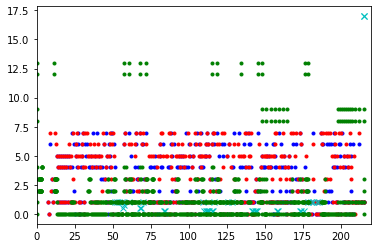

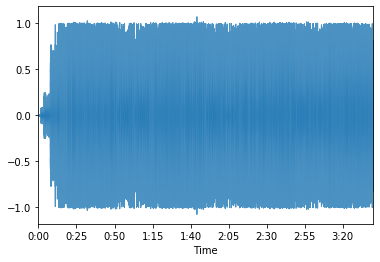

In [57]:
disp_plots_for_time_indices(0, int(notes_df_ex["time_seconds"].max()), notes_df_ex, waves_ex, sample_rate_ex)

You can already see an increase in the number of notes on the expert version even from the full song view

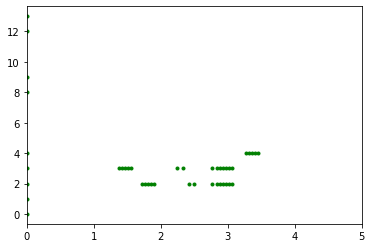

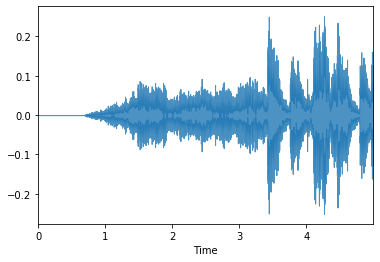

In [58]:
disp_plots_for_time_indices(0, 5, notes_df_ex, waves_ex, sample_rate_ex)

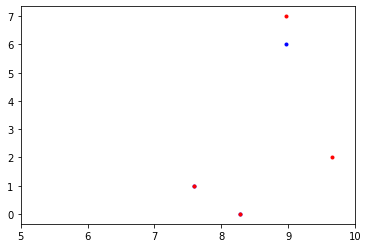

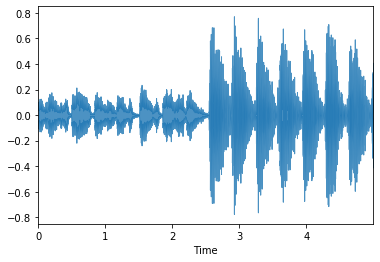

In [59]:
disp_plots_for_time_indices(5, 10, notes_df_ex, waves_ex, sample_rate_ex)

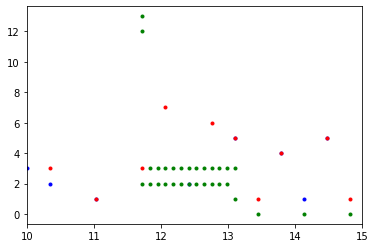

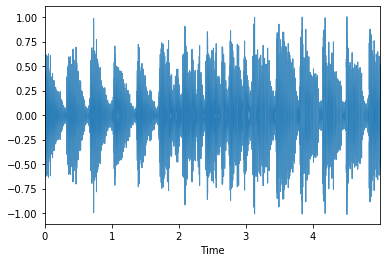

In [60]:
disp_plots_for_time_indices(10, 15, notes_df_ex, waves_ex, sample_rate_ex)

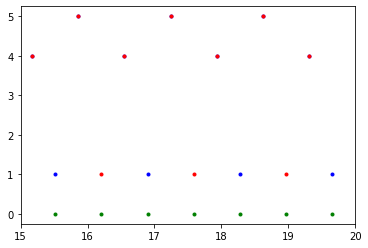

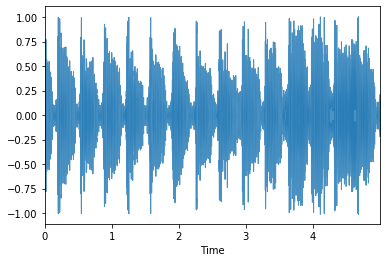

In [61]:
disp_plots_for_time_indices(15, 20, notes_df_ex, waves_ex, sample_rate_ex)

As expected, the expert mode has more notes and uses more of the onsets than normal does.

After looking at those plots it would seem that we need to be looking for a machine learning algorithm that will learn to detect onsets of the waveform and then map an appropriate noteblock into the same time (converted into the "beat" for beat saber). 

Events are a bit harder to determine, but events are a lot less important than notes themselves so it should be okay even if the algorithm essentially ends up guessing at the lighting.

Also, since librosa returns numpy arrays, it will not be difficult to obtain a numeric representation of these waveforms. As shown above we can even take 5 second slices of the song in order to avoid feeding the algorithm an entire song at once. (An alternate option that I have also seen people use is to simply feed the picture of the waveform or spectrograph to the algorithm instead. That can be a backup option if I am unable to get the numeric waveform values to work well for this.)

**Conclusion**
In this notebook we have loaded the metadata from a previously downloaded csv file and then done various cleaning steps to it.

In section 1 we removed the community ratings as there were not enough of them to have a consistent mapping.

In section 2 we determined what difficulties each song had from the song information on the local drive. 

In section 3 we removed any songs that had no valid difficulties. 

In section 4 we analyzed the difficulties and gathered a few more pieces of metadata (some of which that we discarded due to lack of use)

In section 5 we gathered song lengths via librosa on the song files themselves

In section 6 we gathered the data for song objects (notes, bombs, obstacles, and lighting events) from each song's individual json file. We also exploded the songs out by difficulty so that we had a single row per song per difficulty

In section 7 we looked at the statistics and culled hundreds of maps that would not be useful for the algorithm (either due to too high note density, or too low).

In section 8 we looked at some plots of the song waveforms against the actual beat saber objects and when they occur and drew some conclusions about what the machine learning algorithm will have to look at.